1. Temat projektu

Wyznaczanie minimalnego okręgu i prostokąta zawierającego chmurę punktów na płaszczyźnie

Reference: https://prezi.com/ehey3lpea0dy/wyznaczanie-minimalnego-okregu-i-prostokata-zawierajacego-ch/

2. Potrzebne biblioteki

In [1]:
import copy
import functools
import random
import math
from collections import deque
from bitalg.visualizer.main import Visualizer

3. Testowe zbiory punktów

3.1. Funkcje generujące punkty na płaszczyźnie

In [2]:
def generate_uniform_points(left=-100, right=100, n=100):

    T = []

    for i in range( n ):

        T.append((random.uniform(left, right), random.uniform(left, right)))
        
    return T

In [3]:
def generate_circle_points(O, R, n=100):
    
    T = []
    
    for i in range(n):

        f = random.uniform(0, 2) * math.pi

        x = R * math.cos(f) - O[0]
        y = R * math.sin(f) - O[1]

        T.append((x,y))
        
    return T

In [4]:
def generate_rectangle_points(a=(-10, -10), b=(10, -10), c=(10, 10), d=(-10, 10), n=100):

    T = []

    v1 = (a[0] - b[0], a[1] - b[1])
    v2 = (b[0] - c[0], b[1] - c[1])
    v3 = (c[0] - d[0], c[1] - d[1])
    v4 = (d[0] - a[0], d[1] - a[1])

    for i in range(n):
        x = random.randint(1, 4)
        y = random.random()

        if x ==1:
            T.append( (b[0] + v1[0] * y, b[1] + v1[1] * y) )
        elif x == 2:
            T.append( (c[0] + v2[0] * y, c[1] + v2[1] * y) )
        elif x == 3:
            T.append( (d[0] + v3[0] * y, d[1] + v3[1] * y) )
        else:
            T.append( (a[0] + v4[0] * y, a[1] + v4[1] * y) )
        
        
        #T.append((c, (a[1] - b[1]) / (a[0] - b[0]) * c + ( a[1] - ((a[1] - b[1]) / (a[0] - b[0])) * a[0] )))
    
    return T

In [5]:
def generate_square_points(a=(0, 0), b=(10, 0), c=(10, 10), d=(0, 10), axis_n=25, diag_n=20):

    T = []

    v1 = (a[0] - b[0], a[1] - b[1])
    v2 = (d[0] - a[0], d[1] - a[1])

    for i in range(axis_n):
        
        y = random.random()
        
        T.append( (b[0] + v1[0] * y, b[1] + v1[1] * y) )
        
    for i in range(axis_n):

        y = random.random()
    
        T.append( (a[0] + v2[0] * y, a[1] + v2[1] * y) )

    d1 = (b[0] - d[0], b[1] - d[1])
    d2 = (a[0] - c[0], a[1] - c[1])
    
    for i in range(diag_n):

        y = random.random()

        T.append( (d[0] + d1[0] * y, d[1] + d1[1] * y) )

    for i in range(diag_n):

        y = random.random()

        T.append( (c[0] + d2[0] * y, c[1] + d2[1] * y) )

    T.append( a )
    T.append( b )
    T.append( c )
    T.append( d )

    
    return T

3.2. Wygenerowane zbiory punktów

In [6]:
%matplotlib inline

In [129]:
points_a = generate_uniform_points(-100, 100, 200)

In [8]:
points_aa = generate_uniform_points(-100, 100, 4)

In [9]:
points_b = generate_circle_points((0, 0), 10, 100)

In [10]:
points_c = generate_rectangle_points((-10, -10), (10, -10), (10, 10), (-10, 10), 100)

In [11]:
points_d = generate_square_points((0, 0), (10, 0), (10, 10), (0, 10), 25, 20)

In [12]:
import matplotlib.pyplot as plt

def add_sections(n = 10, xLimit = (0, 10), yLimit = (0, 10)):
    
    vertices = []
    sections_ = []
    
    def on_click(event):
        
        if event.inaxes:

            plt.plot(event.xdata, event.ydata, 'o')

            vertices.append((event.xdata, event.ydata))

            plt.show()

            if len(vertices) >= n:
                    
                %matplotlib inline

                plt.close()
               

                
                
            
    
    %matplotlib tk

    fig, ax = plt.subplots()
    ax.plot()

    plt.setp(ax, xlim=xLimit, ylim=yLimit)
    plt.connect('button_press_event', on_click)

    plt.show()    
    
    return vertices

In [13]:
#points_custom = add_sections()

3.3. Wizualizacja wygenerowanych zbiorów

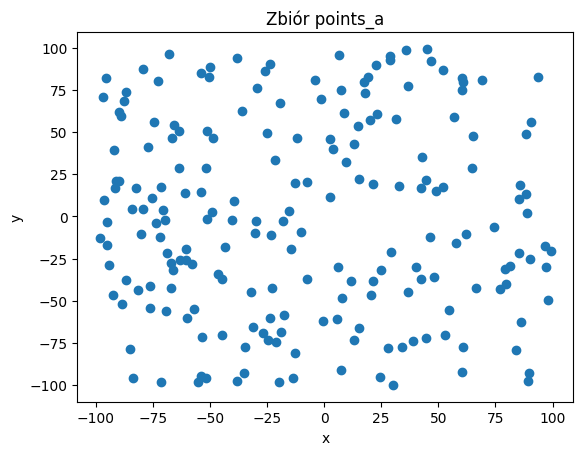

In [130]:
vis = Visualizer()
vis.add_title('Zbiór points_a')
vis.add_point(points_a)
vis.show()

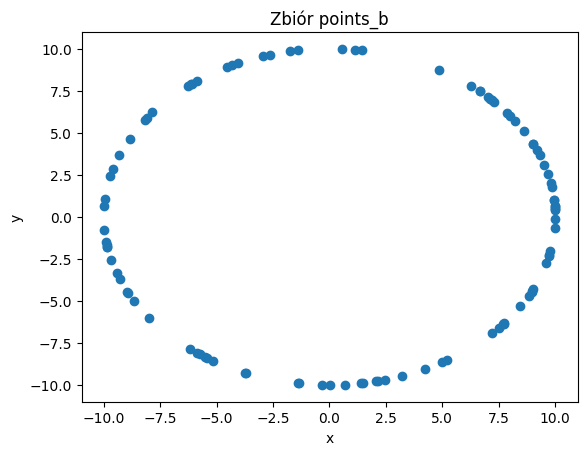

In [15]:
vis = Visualizer()
vis.add_title('Zbiór points_b')
vis.add_point(points_b)
vis.show()

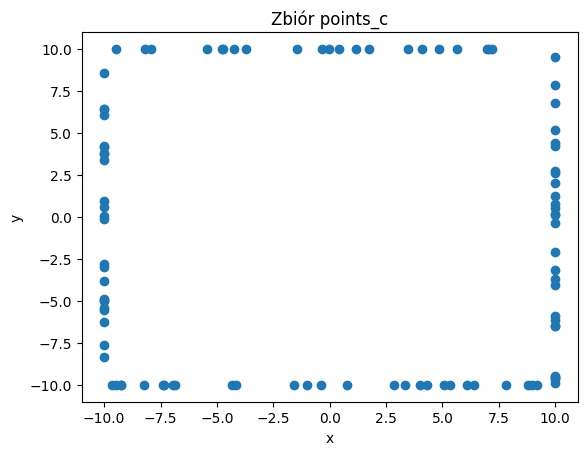

In [16]:
vis = Visualizer()
vis.add_title('Zbiór points_c')
vis.add_point(points_c)
vis.show()

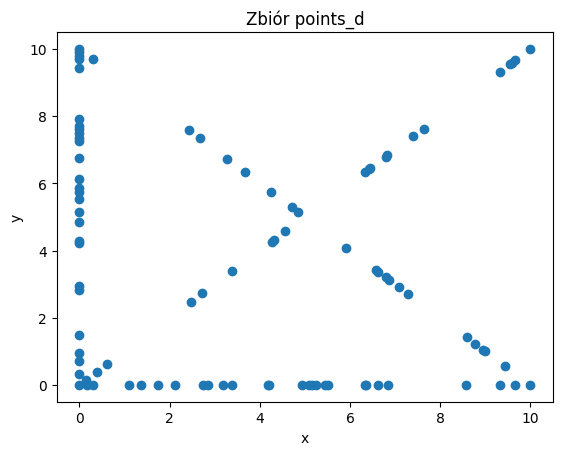

In [17]:
vis = Visualizer()
vis.add_title('Zbiór points_d')
vis.add_point(points_d)
vis.show()

4. Algorytm Grahama - zaimplementowany na zajęciach

In [86]:
def det(a, b, c):
    return (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])

def distance(P, A, B):
    
    #Wektor PA
    PA = (A[0] - P[0], A[1] - P[1])

    #Moduł wektora PA
    PA_mod = (PA[0] ** 2 + PA[1] ** 2)**(0.5)   

    #Wektor PB
    PB = (B[0] - P[0], B[1] - P[1])

    #Moduł wektora PB
    PB_mod = (PB[0] ** 2 + PB[1] ** 2)**(0.5)

    if PA_mod > PB_mod:
        return 1
    else:
        return -1

def cmp(P, A, B, eps = 0):
    
    # -1 - B jest po lewej od PA
    # 1 - B jest po prawej od PA
    # 0 - B jest na PA

    calculatedOrientation = orient(P, A, B)
    
    if calculatedOrientation != 0:
        return calculatedOrientation
    else:
        return distance(P, A, B)

def orient(P, A, B, eps = 0):
    
    # -1 - B jest po lewej od PA
    # 1 - B jest po prawej od PA
    # 0 - B jest na PA
    
    res = det(P, A, B)
    
    if res < -eps: #B leży po prawej stronie od PA
        return 1
    elif res > eps: #B leży po lewej stronie od PA
        return -1
    else:
        return 0

def graham_algorithm(X):

    #Zbiór pusty
    if len(X) == 0:
        return []
    
    #Kopiuję tablicę, żeby nie zniszczyć oryginalnej, która potem jest używana do wyświetlania
    Q = copy.deepcopy(X) 

    #Punkt początkowy o najmiejszej współrzędnej y oraz x
    P = min(Q, key = lambda l: (l[1],l[0])) 

    #Pozbywam się P z listy
    Q.remove(P) 
    
    #Sortuje zbiór punktów po najmniejszym kącie między prostą P - Punkt względem OX
    Q = [P] + sorted(Q, key=functools.cmp_to_key(lambda A, B: cmp(P, A, B)))
    
    #Tworze stos
    stack = deque()
    
    #Wrzucam 3 pierwsze punkty na stos (w tym P)
    
    if len(Q) > 0:
        stack.append(Q[0])
    else:
        return list(stack)
        
    if len(Q) > 1:
        stack.append(Q[1])
    else:
        return list(stack)
        
    if len(Q) > 2:    
        stack.append(Q[2])
    else:
        return list(stack)
    
    # Jeśli wsród 3 pierwszych punktów dwa są współliniowe to usuwam ten na szyczycie stosu (bo są posortowane rosnąco)
    if orient(stack[-3], stack[-2], stack[-1]) == 0: 
        stack.pop()
        
    
    i = 3
    
    while i < len(Q):
        A = stack[-2]
        B = stack[-1]
        C = Q[i]

        if orient(A, B, C) == 0: #B i C są współlinowe (Ale także posortowane rosnąco, więc usuwam ten pierwszy bo będzie mniejszy)

            stack.pop()
            stack.append(Q[i])
            i += 1
        elif orient(A, B, C) == 1: 
            
            stack.pop()
        else:
            stack.append(Q[i])
            i += 1

    graham_points_a = list(stack)

    #for i in range(len(graham_points_a) - 1):
    #    vis.add_line_segment( (graham_points_a[i], graham_points_a[i+1]) )
    #vis.add_line_segment([graham_points_a[-1], graham_points_a[0]])
    
    return graham_points_a

In [135]:
hull_points_a = graham_algorithm(points_a)

In [136]:
hull_points_b = graham_algorithm(points_b)

In [137]:
hull_points_c = graham_algorithm(points_c)

In [138]:
hull_points_d = graham_algorithm(points_d)

4.1 Wizualizacja działania algorytmu Grahama

In [143]:
def show_convex_hull(points, hull_points):

    vis = Visualizer()
    vis.add_point(points)

    for i in range(1, len(hull_points)):
        vis.add_line_segment( (hull_points[i - 1], hull_points[i]) )
    vis.add_line_segment( (hull_points[-1], hull_points[0]) )

    vis.show()

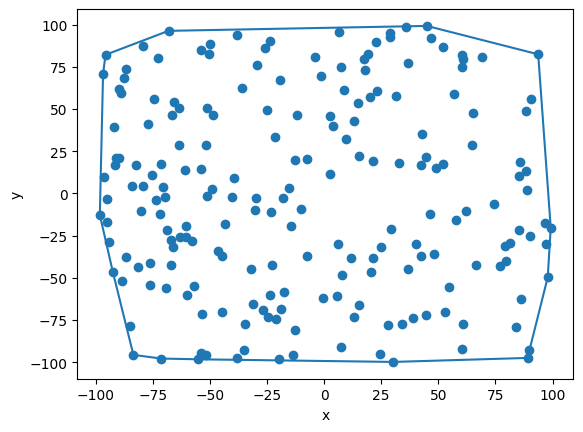

In [144]:
show_convex_hull(points_a, hull_points_a)

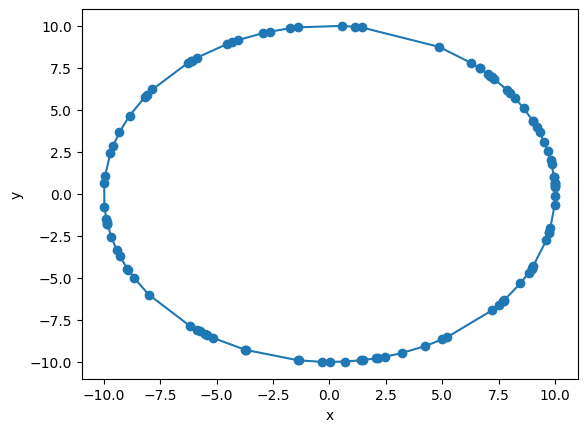

In [145]:
show_convex_hull(points_b, hull_points_b)

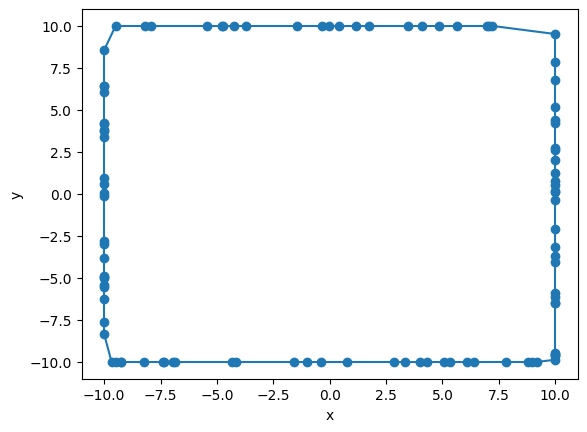

In [146]:
show_convex_hull(points_c, hull_points_c)

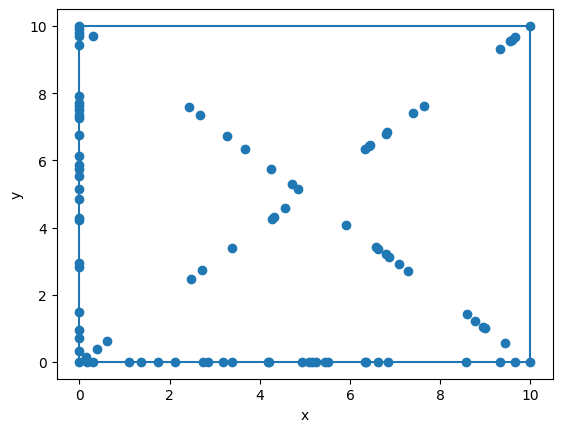

In [147]:
show_convex_hull(points_d, hull_points_d)

5. Najmniejszy prostokąt

Niech mbr - minimal bounding rectangle.
Korzystamy z faktu, że przynajmniej jeden bok mbr jest równoległy do jednego z boków otoczki wypukłej.
1. Wyznaczam punkty tworzące otoczkę wypukłą za pomocą algorytmu Grahama O(nlogn)
2. Wyznaczam wetkory dla każdej krawędzi otoczki
3. Normalizuję te wektory (tzn. Dzielę je przez ich długość) w celu uproszczenia obliczeń (Działałoby
bez normalizacji, ale dużo lepiej wykonywać operacje na małych liczbach)
4. Wyznaczam wektory prostopadłe:
    Dla wektora [a, b] na płaszczyźnie 2D można wyznaczyć dwa wektory prostopadłe:
        - [-b, a]
        - [b, -a]
    W tym przypadku nie ma znaczenia który weźmiemy, zatem wybieram ten pierwszy
5. Szukam najbardziej wysuniętych wartości względem wektora

In [175]:
def mbr(hull_points):
    vis = Visualizer()
    #Krawędzie
    edges = []
    for i in range(1, len(hull_points)):
        edges.append( (hull_points[i - 1], hull_points[i]) )
    edges.append( (hull_points[-1], hull_points[0]) )

    #Wektory kierunkowe krawędzi
    dir_vec = []
    for edge in edges:
        dir_vec.append( ( (edge[1][0] - edge[0][0]), (edge[1][1] - edge[0][1]) ) )

    #Długości krawędzi (długości wektorów)
    edges_len = []
    for vec in dir_vec:
        edges_len.append( (vec[0]**2 + vec[1]**2)**(1/2) ) 

    #Normalizacja wektorów
    norm_vec = []
    for i in range(len(dir_vec)):
        norm_vec.append( (dir_vec[i][0] / edges_len[i], dir_vec[i][1] / edges_len[i]) )

    #Wektory prostopadłe
    perp_vec = []
    for i in range(len(norm_vec)):
        perp_vec.append( (-norm_vec[i][1], norm_vec[i][0]) )

    #Mnożę punkty przez wektory i szukam wartosci maksymalnych i minimalnych
    
    minX = [] 
    maxX = [] 

    for i in range(len(norm_vec)):

        minXVal = float('inf')
        maxXVal = float('-inf')

        for j in range(len(hull_points)):

            temp = hull_points[j][0] * norm_vec[i][0] + hull_points[j][1] * norm_vec[i][1]

            #vis.add_point(temp, color = 'brown')

            if temp > maxXVal:
                maxXVal = temp
            
            if temp < minXVal:
                minXVal = temp
        
        minX.append(minXVal)
        maxX.append(maxXVal)

        
    minY = []
    maxY = []

    for i in range(len(perp_vec)):
        
        minYVal = float('inf')
        maxYVal = float('-inf')

        for j in range(len(hull_points)):

            temp = hull_points[j][0] * perp_vec[i][0] + hull_points[j][1] * perp_vec[i][1]

            #print(temp)

            if temp > maxYVal:
                maxYVal = temp
            
            if temp < minYVal:
                minYVal = temp
        
        minY.append(minYVal)
        maxY.append(maxYVal)
    minArea = float('inf')
    minAreaIdx = -1
    for i in range(len(minX)):
        area = (minX[i] - maxX[i]) * (minY[i] - maxY[i])

        if area < minArea:
            minArea = area
            minAreaIdx = i

    pts = [(minX[minAreaIdx],minY[minAreaIdx]),
           (maxX[minAreaIdx], minY[minAreaIdx]),
           (maxX[minAreaIdx], maxY[minAreaIdx]),
           (minX[minAreaIdx], maxY[minAreaIdx])]
    
    for i in range(len(pts)):

        pts[i] = (pts[i][0] * norm_vec[minAreaIdx][0] + pts[i][1] * perp_vec[minAreaIdx][0], pts[i][0] * norm_vec[minAreaIdx][1] + pts[i][1] *perp_vec[minAreaIdx][1])

    return pts
    
    

In [176]:
mbr_points_a = mbr(hull_points_a)

In [177]:
mbr_points_b = mbr(hull_points_b)

In [178]:
mbr_points_c = mbr(hull_points_c)

In [179]:
mbr_points_d = mbr(hull_points_d)

5.1 Wizualizacja działania algorytmu mbr

In [156]:
def show_mbr(points, hull_points, mbr_points):

    vis = Visualizer()
    vis.add_point(points)

    for i in range(1, len(hull_points)):
        vis.add_line_segment( (hull_points[i - 1], hull_points[i]) )
    vis.add_line_segment( (hull_points[-1], hull_points[0]) )

    ptsSegments = []
    for i in range(1, len(mbr_points)):
        ptsSegments.append( (mbr_points[i - 1], mbr_points[i]) )
    ptsSegments.append( (mbr_points[-1], mbr_points[0]) )

    vis.add_line_segment(ptsSegments,  color = 'red')

    vis.show()
    

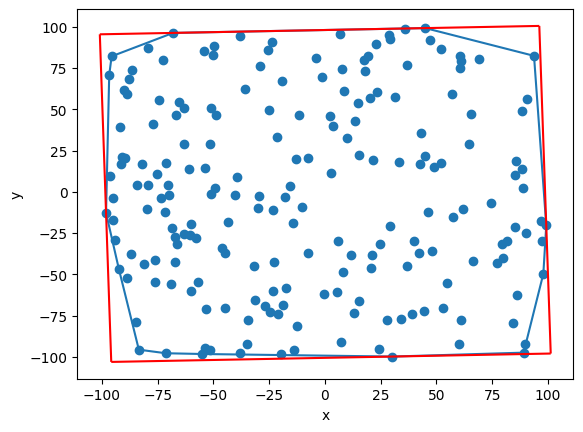

In [180]:
show_mbr(points_a, hull_points_a, mbr_points_a)

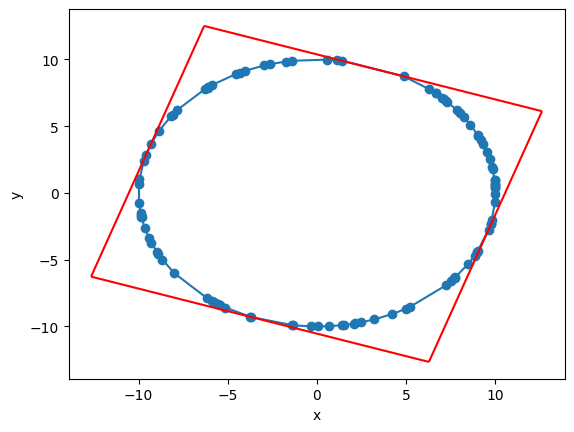

In [181]:
show_mbr(points_b, hull_points_b, mbr_points_b)

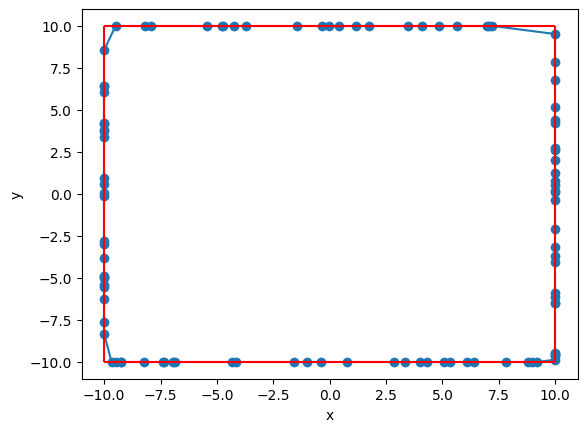

In [182]:
show_mbr(points_c, hull_points_c, mbr_points_c)

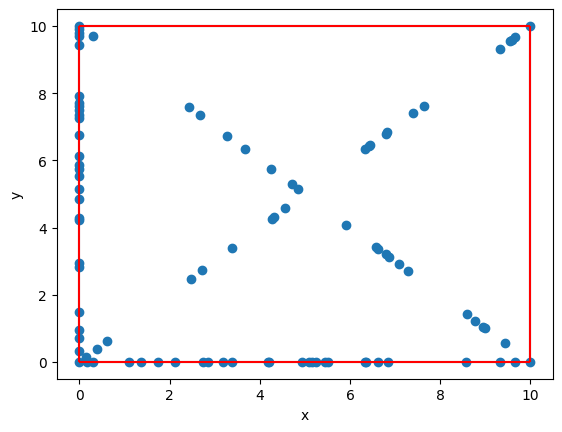

In [183]:
show_mbr(points_d, hull_points_d, mbr_points_d)

6. Algorytm Wezlza

In [22]:
class Circle:

    def __init__(self, S, r):
        self.S = S
        self.r = r

In [39]:
class Circle:

    def __init__(self, S, r):
        self.S = S
        self.r = r

def distance_between_points(A, B):

    C = (B[0] - A[0], B[1] - A[1])

    return (C[0]**(2.0) + C[1]**(2.0))**(0.5)

def center(A, B, C):
    (x1, y1), (x2, y2), (x3, y3) = A, B, C
    A = x1 * (y2 - y3) - y1 * (x2 - x3) + x2 * y3 - x3 * y2
    B = (x1 ** 2 + y1 ** 2) * (y3 - y2) + (x2 ** 2 + y2 ** 2) * (y1 - y3) + (x3 ** 2 + y3 ** 2) * (y2 - y1)
    C = (x1 ** 2 + y1 ** 2) * (x2 - x3) + (x2 ** 2 + y2 ** 2) * (x3 - x1) + (x3 ** 2 + y3 ** 2) * (x1 - x2)
    return (-B / A / 2, -C / A / 2)

def construct_circle(R):

    if len(R) == 0:
        return Circle((0, 0), 0)
    elif len(R) == 1:
        return Circle(R[0], 0)
    elif len(R) == 2:
        
        A = R[0]
        B = R[1]

        S = ( ((A[0] + B[0]) / 2.0), ((A[1] + B[1]) / 2.0) )
        
        r = distance_between_points(A, S)

        return Circle(S, r)
    
    elif len(R) == 3:

        A = R[0]
        B = R[1]
        C = R[2]

        c1 = construct_circle([A, B])
 
        if(in_circle(c1, C)): return c1
            
        c2 = construct_circle([A, C])

        if(in_circle(c2, B)): return c2

        c3 = construct_circle([B, C])

        if(in_circle(c3, A)): return c3


        S = center(A, B, C)

        r = distance_between_points(A, S)

        return Circle(S, r)
    else:
        raise Exception("Wrong \"R\" list size!")

def in_circle(circle, point):
    #print(distance_between_points(circle.S, point) <= circle.r)
    return distance_between_points(circle.S, point) <= circle.r + 10**(-10)


def welzl_algorithm(P, R, last):

    if last == 0 or len(R) == 3:
        return construct_circle(R)
    
    #Wybieram losowo kolejny punkt
    idx = random.randint(0, last - 1)
    point = P[idx]

    #Zamieniam point z ostatnim elementem w P
    P[idx], P[last-1] = P[last-1], P[idx]
    
    #Biorę okrąg zawierający wszystkie punkty poza point
    circle = welzl_algorithm(P, R.copy(), last - 1)

    #Sprawdzam, czy point zawiera się w circle
    if(in_circle(circle, point)):
        #Jeśli tak, to zwracam okrąg
        return circle
    else:
        #Jeśli nie, to point należy do brzegu szukanego okręgu
        R.append(point)

        return welzl_algorithm(P, R.copy(), last - 1)


In [24]:
circle_a = welzl_algorithm(copy.deepcopy(points_a), list([]), len(points_a))
print(circle_a.S, circle_a.r)

(-2.5874701983969715, -8.400694106533471) 120.34968709456093


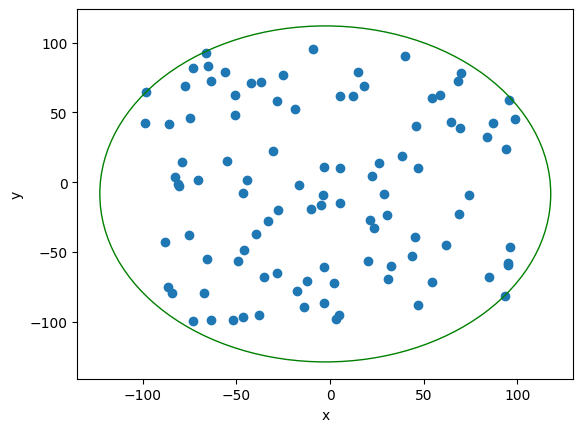

In [25]:
vis = Visualizer()
vis.add_point(points_a)
vis.add_circle((circle_a.S[0], circle_a.S[1], circle_a.r), color='green', fill = False)
vis.show()

Rezultat działania algorytmu Grahama

In [26]:
graham_points_a = graham_algorithm(points_a)

Wizualizacja algorytmu Grahama

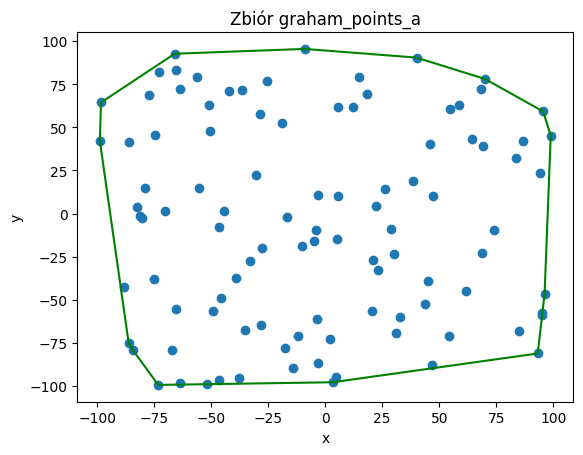

In [27]:
vis = Visualizer()
vis.add_title('Zbiór graham_points_a')
vis.add_point(points_a)
vis.add_line_segment([(graham_points_a[i], graham_points_a[i+1]) for i in range(len(graham_points_a)-1)], color = 'green')
vis.add_line_segment([graham_points_a[-1], graham_points_a[0]], color = 'green')
vis.show()